In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-3fac7503-bb55-35cd-f566-c919eaa55798)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-bf03abcd-ef36-6733-da57-460c8eb9cab4)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-bc01f8f3-0939-f2c0-6998-dd49d0360463)
GPU 3: NVIDIA A100-PCIE-40GB (UUID: GPU-b7aeac00-b332-1045-eebc-bb5653ac8402)


In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/jovyan/fourier_learning_ibm/']
/root/workdir/fourier_learning_ibm


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.circuit.random import random_circuit
from qiskit_aer import *
from qiskit_ibm_runtime import SamplerV2 as Sampler, Batch
from qiskit.visualization import plot_circuit_layout
from setup import setup_backend

from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

from qiskit.circuit import Parameter
from qiskit.quantum_info import (
    Pauli,
    SparsePauliOp,
    entropy,
    Statevector,
    partial_trace,
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
# density matrix simulator
backend_qpu, backend_dm_noiseless, backend_dm_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="density_matrix"
)
# matrix product state simulator
backend_qpu, backend_mps_noiseless, backend_mps_noisy = setup_backend(
    qpu_name="ibm_marrakesh", device="GPU", method="matrix_product_state"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'sx', 'id', 'measure', 'cz', 'x']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155]
  Specific qubit errors: [('sx', (0,)), ('sx', (1,)), ('sx', (2

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
n_qubits = 52

In [ ]:
def create_Hamiltonian(Js, h):
    """
    Parameters:
        Js: numpy.ndarray
            各結合項の強さを表す配列（長さは n_qubits-1 ）
        h: numpy.ndarray
            各サイトの局所磁場を表す配列（長さは n_qubits）

    Returns:
        H: SparsePauliOp
            生成されたハミルトニアン
    """
    pauli_list = []
    coeffs = []

    # 隣接するスピン間の相互作用項 -J * Z_i Z_{i+1}
    for i in range(n_qubits - 1):
        x_p = np.zeros(n_qubits, dtype=bool)
        z_p = np.zeros(n_qubits, dtype=bool)
        z_p[i] = True
        z_p[i + 1] = True
        pauli_list.append(Pauli((z_p, x_p)))
        coeffs.append(-Js[i])

    # 局所磁場項 h * X_i
    for i in range(n_qubits):
        x_p = np.zeros(n_qubits, dtype=bool)
        z_p = np.zeros(n_qubits, dtype=bool)
        x_p[i] = True
        pauli_list.append(Pauli((z_p, x_p)))
        coeffs.append(h[i])

    H = SparsePauliOp(pauli_list, coeffs=coeffs)
    return H

In [6]:
Js = np.ones(n_qubits - 1)
h = np.zeros(n_qubits)
H = create_Hamiltonian(Js, h)
gate = PauliEvolutionGate(H)

st = SuzukiTrotter(order=2, reps=1)
circ = st.synthesize(gate)
# circ.measure_all()
circ.draw("mpl", fold=-1)

NameError: name 'create_Hamiltonian' is not defined

In [12]:
n_samples = 10
rng = np.random.default_rng(42)
entropies = {}

for i in range(n_samples):
    print(f"sample {i}/{n_samples}")
    Js = rng.uniform(0.5, 1.5, n_qubits - 1)
    h = rng.uniform(-1, 1, n_qubits)
    H = create_Hamiltonian(Js, h)
    gate = PauliEvolutionGate(H)
    st = SuzukiTrotter(order=2, reps=1)
    circuit = st.synthesize(gate)

    circuit.remove_final_measurements()
    all_state = Statevector(circuit)
    entropies[i] = []
    for j in range(n_qubits):
        trace_qubits = [k for k in range(n_qubits) if k != j]
        half_state = partial_trace(all_state, trace_qubits)
        entropies[i].append(entropy(half_state, base=2))

sample 0/10
sample 1/10
sample 2/10
sample 3/10
sample 4/10
sample 5/10
sample 6/10
sample 7/10
sample 8/10
sample 9/10


In [13]:
# DataFrame に変換。行がサンプル、列が qubit index
df = pd.DataFrame.from_dict(entropies, orient="index")
display(df)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.371807,0.391309,0.314294,0.095506,0.090506,0.090712,0.872556,0.887224,0.328236,0.296752,0.331663,0.250295
1,0.031228,0.862729,0.862362,0.018138,0.154934,0.158688,0.100788,0.567663,0.576381,0.462424,0.688758,0.587981
2,0.087471,0.614972,0.740531,0.442303,0.006650,0.030085,0.290798,0.283663,0.028998,0.057594,0.422297,0.412105
3,0.068394,0.131651,0.647199,0.912721,0.881792,0.599559,0.266668,0.035216,0.027850,0.000080,0.550672,0.550666
4,0.584963,0.683586,0.392740,0.058012,0.476680,0.649648,0.422028,0.060385,0.532671,0.525918,0.123178,0.086730
5,0.478585,0.941828,0.924633,0.189050,0.823914,0.827259,0.150213,0.080799,0.138551,0.380337,0.324510,0.009587
6,0.818601,0.859228,0.829297,0.765818,0.091027,0.451716,0.457918,0.338636,0.282506,0.509803,0.709679,0.604044
7,0.730163,0.838868,0.638195,0.374726,0.107979,0.852624,0.949950,0.755610,0.993696,0.989978,0.010879,0.005789
8,0.206888,0.232728,0.666173,0.660500,0.486244,0.636135,0.454585,0.000042,0.396139,0.782294,0.762373,0.392292
9,0.215862,0.221638,0.060926,0.003888,0.374933,0.533180,0.635693,0.915250,0.834163,0.080195,0.160698,0.156638


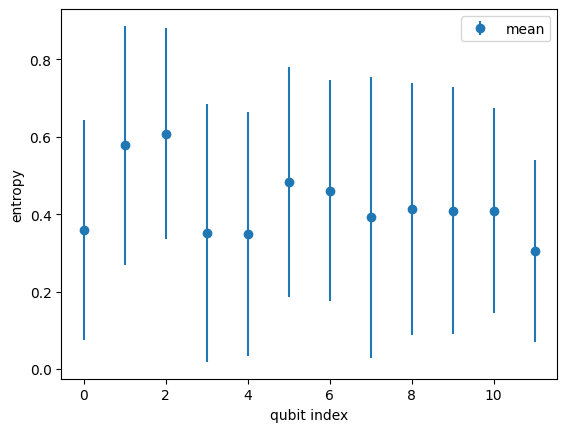

In [14]:
# error bar を plot
entropies_mean = df.mean()
entropies_std = df.std()
plt.errorbar(range(n_qubits), entropies_mean, yerr=entropies_std, fmt="o")
plt.legend(["mean", "std"])
plt.xlabel("qubit index")
plt.ylabel("entropy")
plt.show()

In [ ]:
circ = transpile(circ, backend_qpu)

In [8]:
print(f"depth: {circ.depth()}")
print(f"ops: {circ.count_ops()}")

depth: 663
ops: OrderedDict([('sx', 508), ('rz', 362), ('cz', 202), ('measure', 52), ('barrier', 1)])


In [16]:
%%time
sim = backend_mps_noisy
# sim = backend_dm_noisy
shots = 100

with Batch(backend=sim) as batch:
    sampler = Sampler(mode=batch)
    job = sampler.run([circ], shots=shots)

result = job.result()

print(result[0].data.meas.get_counts())

/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/utils/validations.py:40: UserWarning: The 0-th circuit has no output classical registers so the result will be empty. Did you mean to add measurement instructions?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/qiskit/primitives/backend_sampler_v2.py:158: UserWarning: The 0-th pub's circuit has no output classical registers and so the result will be empty. Did you mean to add measurement instructions?
  warnings.warn(


AttributeError: 'DataBin' object has no attribute 'meas'

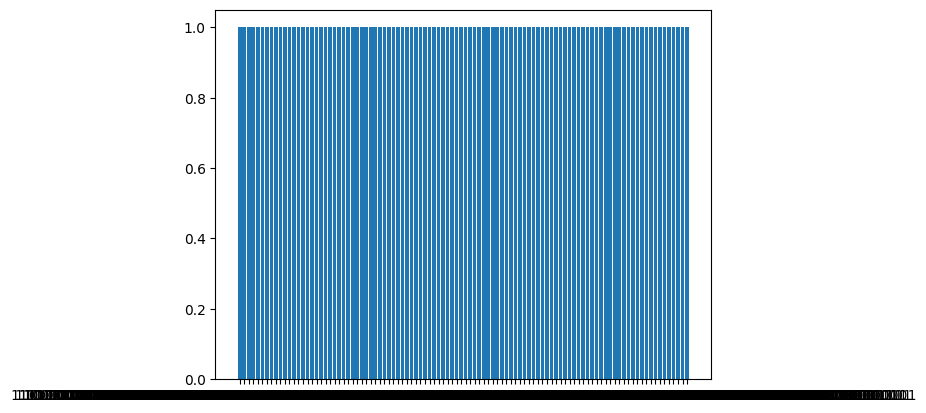

In [9]:
# Plot
import matplotlib.pyplot as plt

plt.bar(
    result[0].data.meas.get_counts().keys(), result[0].data.meas.get_counts().values()
)
plt.show()

In [4]:
import cupy as cp
import time

In [5]:
# 行列のサイズを定義
N = 2**15

start = time.time()
with cp.cuda.Device(0):
    for i in range(10):
        # CuPy を使ってランダムな行列を生成
        A = cp.random.rand(N, N, dtype=cp.float64)
        B = cp.random.rand(N, N, dtype=cp.float64)

        if i == 0:
            # 行列のデータサイズを確認
            print(
                "行列 A のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    A.nbytes, A.nbytes / 1024**3
                )
            )
            print(
                "行列 B のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    B.nbytes, B.nbytes / 1024**3
                )
            )

        C = cp.dot(A, B)
        end = time.time()

        del A, B, C
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

end = time.time()
print("行列積の計算時間: {:.4f}秒".format(end - start))

CUDARuntimeError: cudaErrorNoDevice: no CUDA-capable device is detected

In [1]:
import cupy as cp
import time

# random な疎行列を作成し、その行列積を計算する。計算は cupy で行う
import scipy.sparse
import cupyx.scipy.sparse

# 疎行列のサイズを定義
N = 2**14
density = 0.01

start = time.time()
with cp.cuda.Device(0):
    for i in range(10):
        # CuPy を使ってランダムな疎行列を生成
        A = cupyx.scipy.sparse.random(
            N, N, density=density, format="csr", dtype=cp.float64
        )
        B = cupyx.scipy.sparse.random(
            N, N, density=density, format="csr", dtype=cp.float64
        )

        if i == 0:
            # 疎行列のデータサイズを確認
            print(
                "行列 A のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    A.data.nbytes, A.data.nbytes / 1024**3
                )
            )
            print(
                "行列 B のデータサイズ: {:.2f} B = {:.2f} GB".format(
                    B.data.nbytes, B.data.nbytes / 1024**3
                )
            )

        C = A.dot(B)
        end = time.time()

        del A, B, C
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()

行列 A のデータサイズ: 21474832.00 B = 0.02 GB
行列 B のデータサイズ: 21474832.00 B = 0.02 GB
